## Automatically fit linear regression for OpenTrons plate readings

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install openpyxl

In [4]:
def convert_time_to_seconds(time):
    # convert the time column to seconds since the start to enable calculations
    time2 = pd.to_datetime(time.astype(str), format="mixed")
    seconds_elapsed = []
    for i, x in enumerate(time2.values):
        seconds_elapsed += [pd.Timedelta(x - time2.values[0]).seconds]
    return seconds_elapsed

In [6]:
def get_linear_fit_stats(df):
    # build a dataframe of the slopes and fits
    col_stats = {}
    for c in df.columns[2:98]:
        reg = LinearRegression().fit(X, df[c])
        pred = reg.predict(X)
        
        r2 = r2_score(df[c], pred)
        slope = reg.coef_[0]
        col_stats[c] = {'slope': slope,
                        'r2': r2,
                        'y-intercept': pred[0],
                        '1/slope': 1/slope
                       }
        
    df_slopes = pd.DataFrame(col_stats).T
    df_slopes = df_slopes.sort_values("slope", ascending=False)
    return df_slopes

In [7]:
# Parse all sheets and write the linear fits
# Need to give the path/to/file
opentrons_file = "SsGdh_Batch2_TestingData_Rnd2.xlsx"
# 24 sheets for 24 plates. TODO automatically figure out number of sheets
sheet_stats = {}
for sheet_idx in range(1,25):
    sheet_name = f"Plate {sheet_idx} - Sheet1"
    print(f"Parsing {sheet_name}")
    sheet_data = pd.read_excel(opentrons_file, 
                       sheet_name=sheet_name, 
                       header=26, 
                       index_col=0).reset_index(drop=True)
    sheet_data["seconds"] = convert_time_to_seconds(sheet_data.Time)
    X = sheet_data.seconds.values.reshape((-1, 1))
    df_stats = get_linear_fit_stats(sheet_data)
    sheet_stats[f"Plate {sheet_idx}"] = df_stats

out_file = opentrons_file.replace(".xlsx", "_linear_fits.xlsx")
print(f"writing {out_file}")
with pd.ExcelWriter(out_file) as writer:
    for name, df in sheet_stats.items():
        df.to_excel(writer, sheet_name=name)

Parsing Plate 1 - Sheet1
Parsing Plate 2 - Sheet1
Parsing Plate 3 - Sheet1
Parsing Plate 4 - Sheet1
Parsing Plate 5 - Sheet1
Parsing Plate 6 - Sheet1
Parsing Plate 7 - Sheet1
Parsing Plate 8 - Sheet1
Parsing Plate 9 - Sheet1
Parsing Plate 10 - Sheet1
Parsing Plate 11 - Sheet1
Parsing Plate 12 - Sheet1
Parsing Plate 13 - Sheet1
Parsing Plate 14 - Sheet1
Parsing Plate 15 - Sheet1
Parsing Plate 16 - Sheet1
Parsing Plate 17 - Sheet1
Parsing Plate 18 - Sheet1
Parsing Plate 19 - Sheet1
Parsing Plate 20 - Sheet1
Parsing Plate 21 - Sheet1
Parsing Plate 22 - Sheet1
Parsing Plate 23 - Sheet1
Parsing Plate 24 - Sheet1
writing SsGdh_Batch2_TestingData_Rnd2_linear_fits.xlsx


In [3]:
# example for a single sheet
opentrons_file = "SsGdh_Batch2_TestingData_Rnd2.xlsx"
data = pd.read_excel(opentrons_file, header=26, index_col=0).reset_index(drop=True)
data.head(2)

,Time,T° A358:358,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,00:00:00,25.5,0.219,0.217,0.204,0.232,0.238,0.243,0.231,0.210,...,0.216,0.216,0.226,0.231,0.234,0.206,0.230,0.223,0.222,0.215
1,00:31:40,25.5,0.222,0.219,0.206,0.233,0.237,0.243,0.234,0.213,...,0.219,0.219,0.226,0.232,0.234,0.209,0.231,0.228,0.224,0.217


## Plot the time course data

In [8]:
# choose a sheet and load the data
sheet_name = f"Plate 1 - Sheet1"
data = pd.read_excel(opentrons_file, 
                   sheet_name=sheet_name, 
                   header=26, 
                   index_col=0).reset_index(drop=True)

data["seconds"] = convert_time_to_seconds(data.Time)
X = data.seconds.values.reshape((-1, 1))
df_stats = get_linear_fit_stats(data)

In [11]:
markers = [".", ",", "o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D"]
colors = sns.color_palette(n_colors=13)

In [12]:
df_stats.head(5)

,slope,r2,y-intercept,1/slope
D5,0.000003,0.287560,0.276263,394654.773358
D9,0.000002,0.236198,0.269948,418166.662121
D6,0.000002,0.289658,0.283567,425026.647940
D7,0.000002,0.257835,0.256223,461643.310353
C7,0.000002,0.285488,0.260088,493480.251849


In [13]:
df_stats.index[0:5]

Index(['D5', 'D9', 'D6', 'D7', 'C7'], dtype='object')

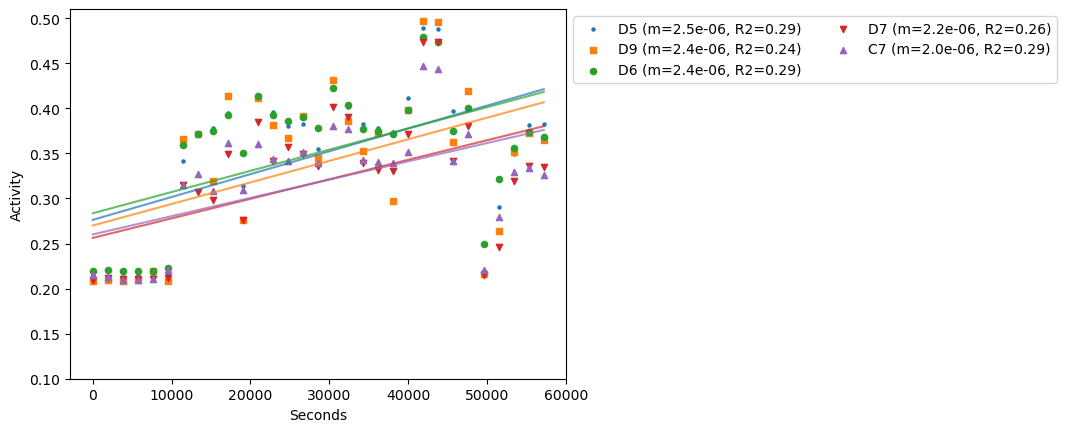

In [14]:
# Plot one (or a few) at a time
f, ax = plt.subplots()
# Plot the 5 wells with the highest slopes
cols = df_stats.index[0:5]
# Can also just choose any wells
# cols = ["B5", "D8", "H2"]
for i, c in enumerate(cols):
    reg = LinearRegression().fit(X, data[c])
    pred = reg.predict(X)
    label = f"{c} (m={df_stats.loc[c].slope:0.1e}, R2={df_stats.loc[c].r2:0.2f})"
    
    color = colors[i]
    ax.plot(X, pred, alpha=0.7, color=color)
    
    marker = markers[i]
    data.plot.scatter(x="seconds", y=c, ax=ax,
                      label=label, 
                      color=[color], marker=marker)
    
    ax.set_ylim(0.1, 0.51)
    ax.set_ylabel("Activity")
    ax.set_xlabel("Seconds")

    ax.legend(ncol=2, bbox_to_anchor=(1,1))
plt.show()
plt.close()

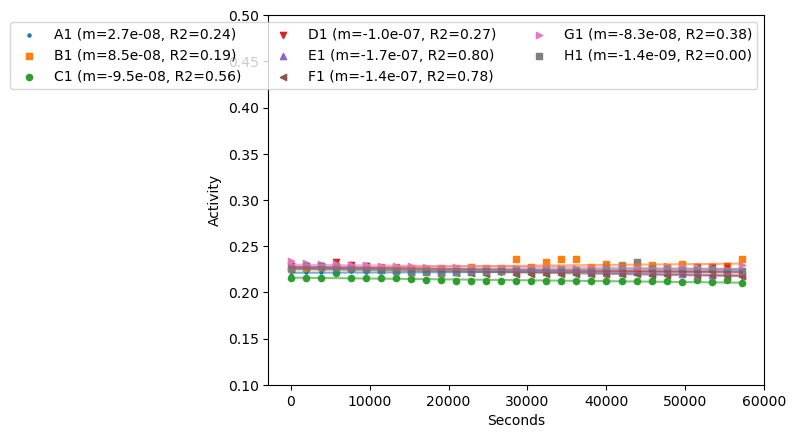

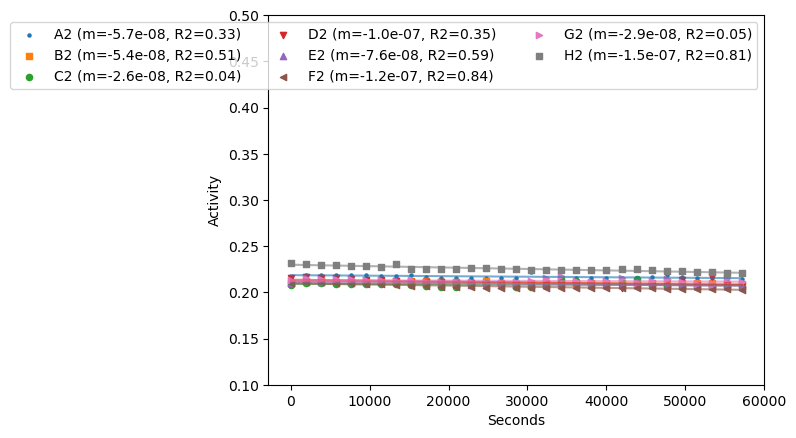

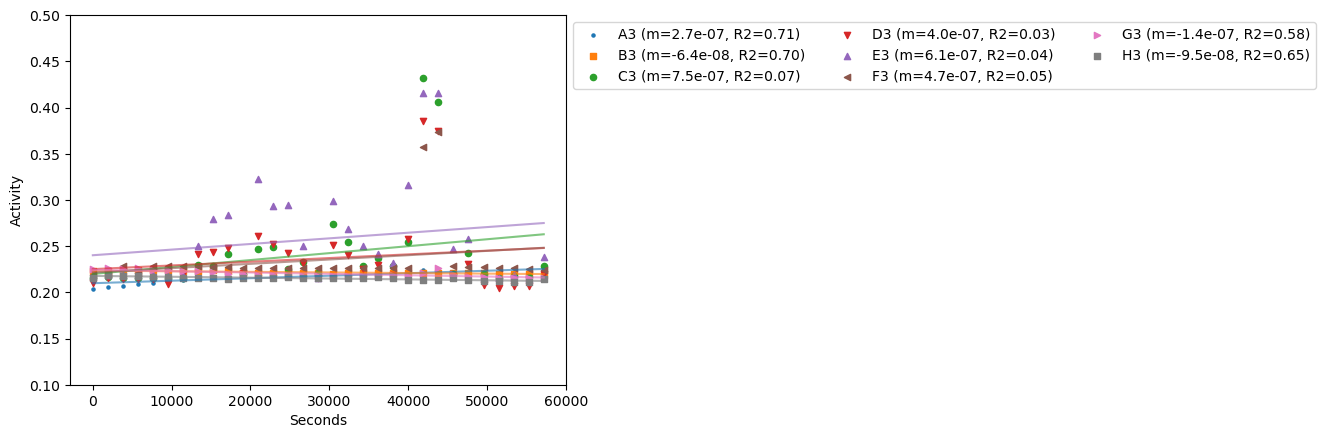

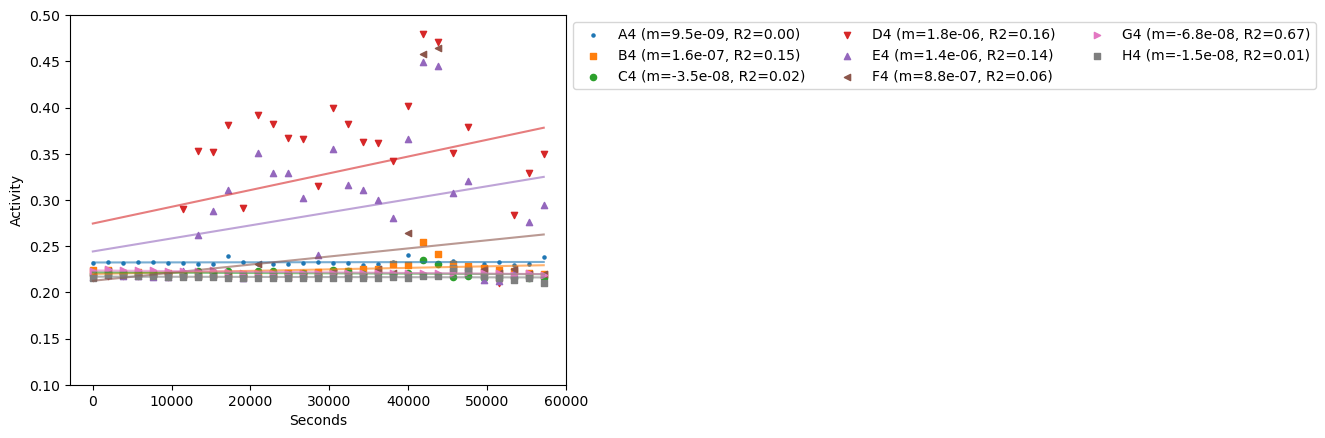

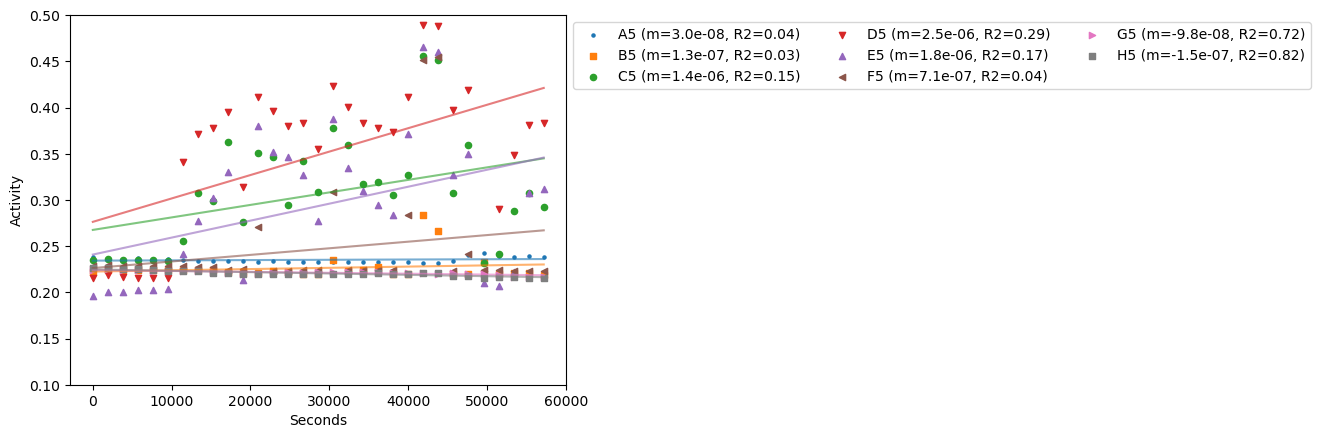

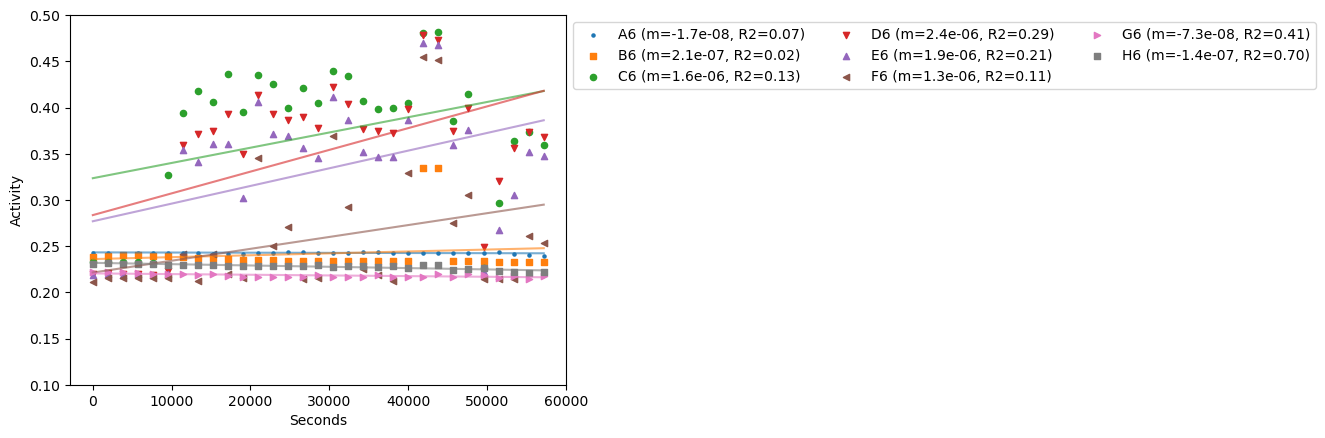

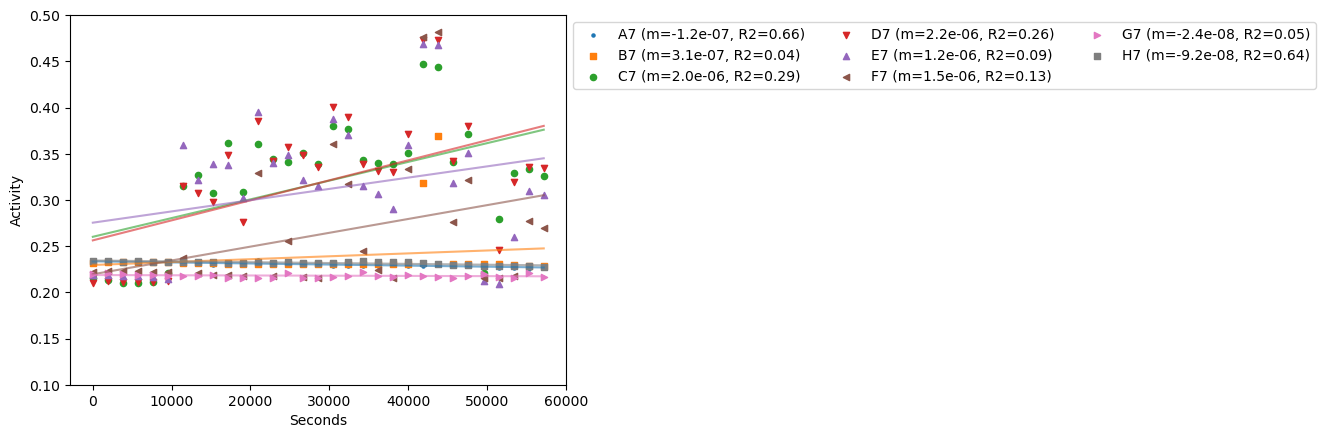

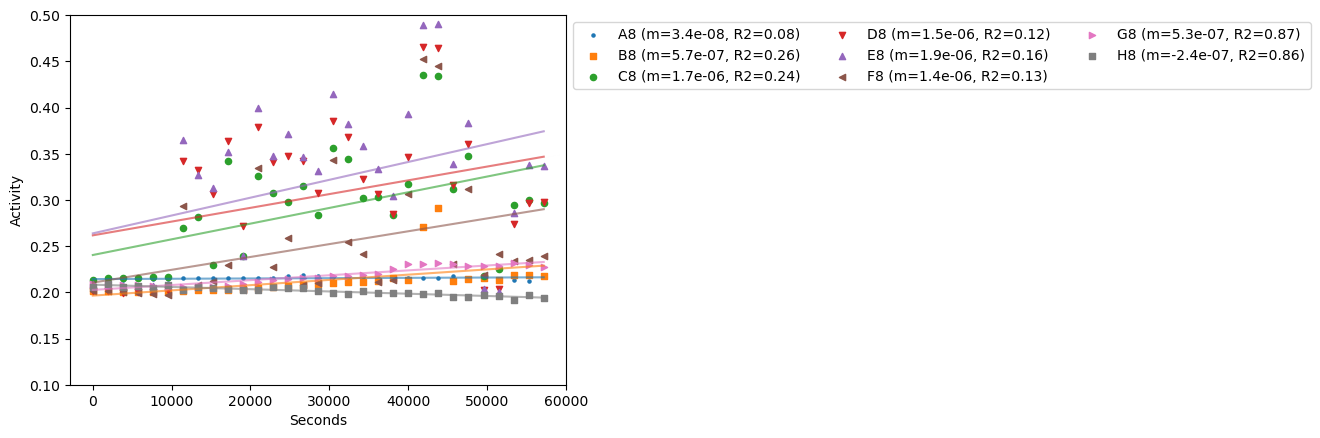

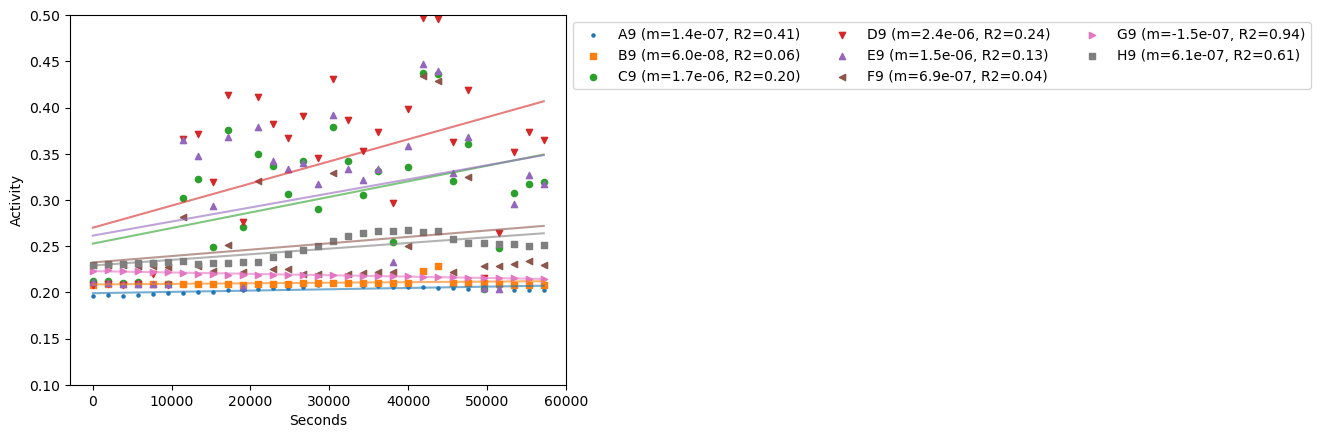

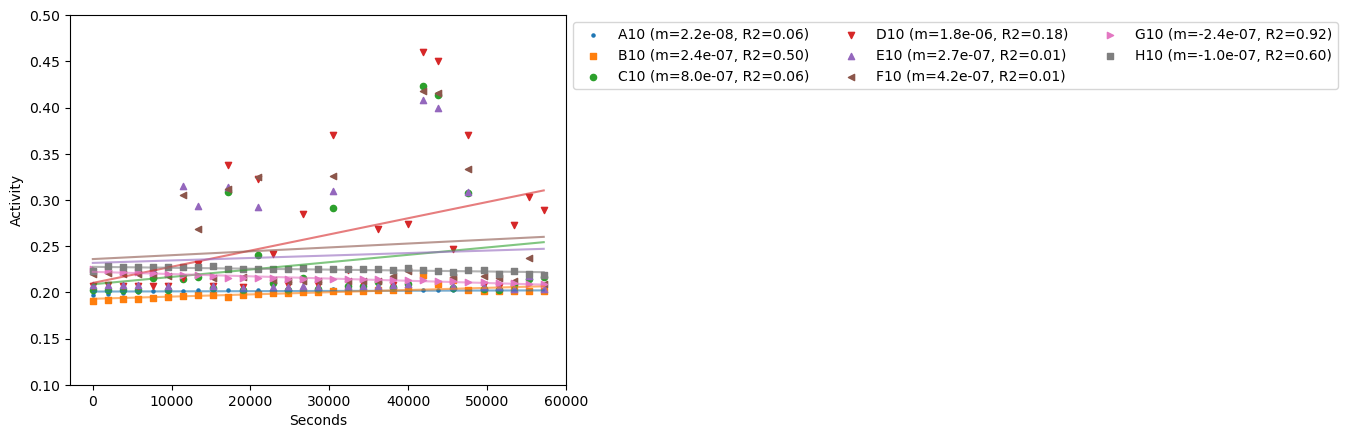

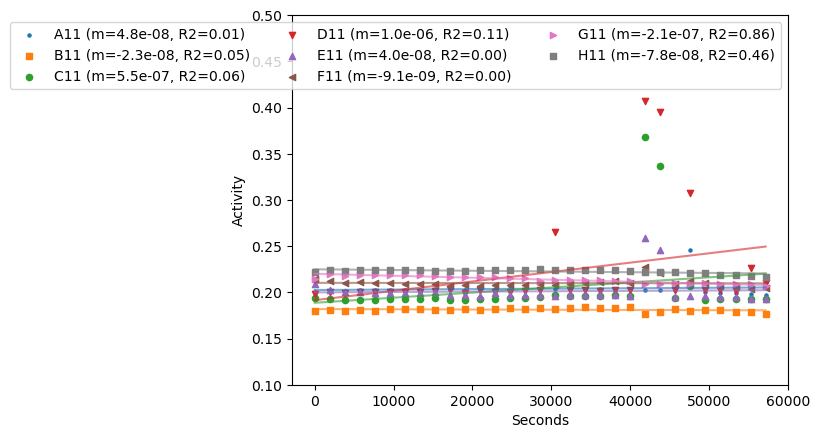

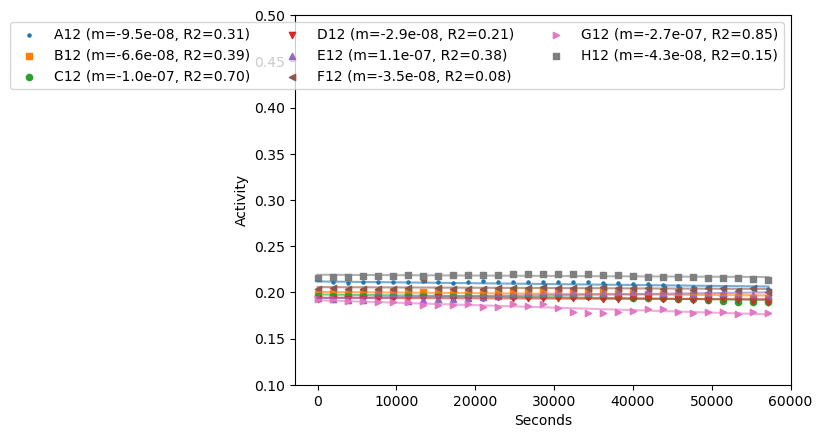

In [197]:
# make one plot per column on the plate (i.e., each letter)
for num in range(1, 13):
    f, ax = plt.subplots()
    for i, letter in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
        c = f"{letter}{num}"
        if c not in data.columns:
            print(f"'{c}' not found. skipping")
            continue
            
        reg = LinearRegression().fit(X, data[c])
        pred = reg.predict(X)
        label = f"{c} (m={df_stats.loc[c].slope:0.1e}, R2={df_stats.loc[c].r2:0.2f})"
    
        # choose a random color and shape
        # color = np.random.rand(3,)
        # marker = markers[np.random.randint(len(markers))]
        color = colors[i]
        ax.plot(X, pred, alpha=0.6, color=color)
        marker = markers[i]
        data.plot.scatter(x="seconds", y=c, ax=ax,
                          label=label, 
                          color=[color], marker=marker)
        
        ax.set_ylim(0.1, 0.5)
    
    ax.legend(ncol=3, bbox_to_anchor=(1,1))
    ax.set_ylabel("Activity")
    ax.set_xlabel("Seconds")
    plt.show()
    plt.close()
    # break